In [103]:
import pandas as pd
import numpy as np
from collections import Counter

import re
import unicodedata
import gensim
import string
import os
import contractions
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

import spacy
from spacy.lang.en.stop_words import STOP_WORDS as stopwords_spacy
from bs4 import BeautifulSoup
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import time

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import rcParams
plt.style.use("ggplot")

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\developer\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\developer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\developer\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### You can get dataset via:
- https://www.kaggle.com/competitions/nlp-getting-started/data

In [104]:
df_train=pd.read_csv("train.csv")
df_test=pd.read_csv("test.csv")
print("shape of train dataset:",df_train.shape)
print("shape of test dataset:",df_test.shape)

shape of train dataset: (7613, 5)
shape of test dataset: (3263, 4)


In [105]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [106]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [107]:
# look 5 samples in text feature within train data
for i in range(5):
    print(df_train["text"][i])

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Forest fire near La Ronge Sask. Canada
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
13,000 people receive #wildfires evacuation orders in California 
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 


In [108]:
# look 5 samples in text feature within train data
for i in range(5):
    print(df_test["text"][i])

Just happened a terrible car crash
Heard about #earthquake is different cities, stay safe everyone.
there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all
Apocalypse lighting. #Spokane #wildfires
Typhoon Soudelor kills 28 in China and Taiwan


### df_train missing values

<AxesSubplot:>

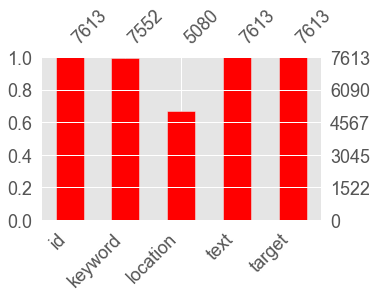

In [109]:
msno.bar(df_train,fontsize = 18, color = 'red',figsize=(5,3))

### df_test missing values

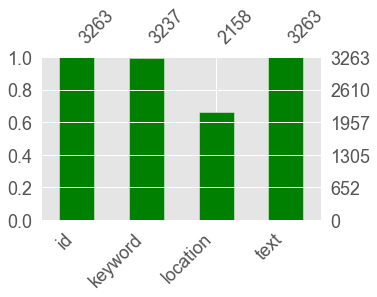

In [110]:
msno.bar(df_test,fontsize = 18, color = 'green',figsize=(5,3))
plt.show()

<button type="button" class="btn btn-primary btn-lg btn-block">EDA (Exploratory Data Analysis)</button></button>

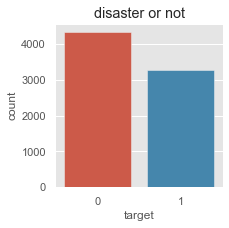

In [111]:
ax=sns.countplot(data=df_train,x="target")
plt.title("disaster or not")
sns.set(rc={'figure.figsize':(3,3)})

In [112]:
df_train["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

<AxesSubplot:ylabel='target'>

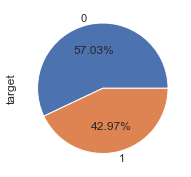

In [113]:
df_train["target"].value_counts().plot.pie(autopct="%1.2f%%")

### Keyword feature visualisation

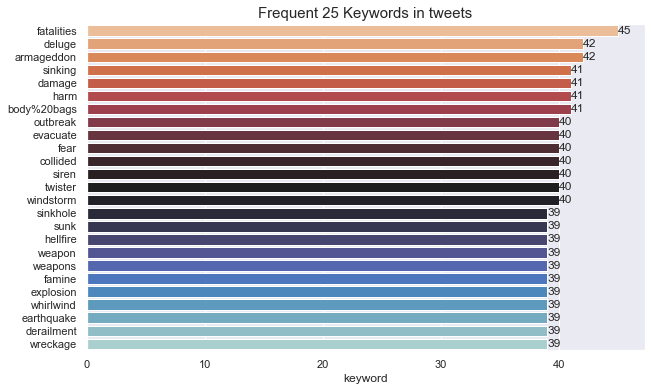

In [114]:
freq_no=25
freq_keywords=df_train["keyword"].value_counts()[:freq_no]
fig,ax = plt.subplots(figsize=(10,6))
ax=sns.barplot(y=freq_keywords.index,x=freq_keywords,data=df_train,palette="icefire_r")

for container in ax.containers:
    ax.bar_label(container)
plt.title(f"Frequent {freq_no} Keywords in tweets",fontsize=15)
plt.show()

### We can see frequent first 25 keywords in tweets

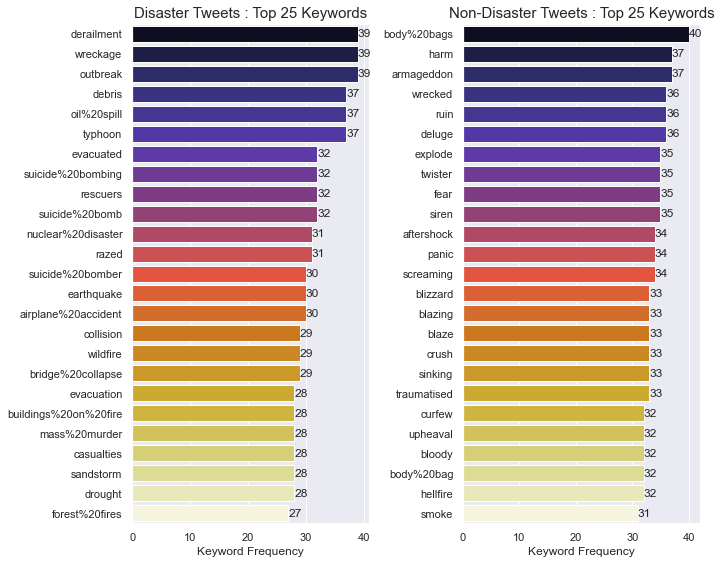

In [115]:
freq_disaster_keywords = df_train.loc[df_train["target"] == 1]["keyword"].value_counts()[:freq_no]
freq_nondisaster_keywords = df_train.loc[df_train["target"] == 0]["keyword"].value_counts()[:freq_no]

fig, ax = plt.subplots(1,2, figsize=(10,8))
ax1 = sns.barplot(y=freq_disaster_keywords.index, x=freq_disaster_keywords, orient='h', ax=ax[0], palette="CMRmap")
for container in ax1.containers:
    ax1.bar_label(container)
ax[0].set_title(f"Disaster Tweets : Top {freq_no} Keywords",fontsize=15)
ax[0].set_xlabel("Keyword Frequency")

ax2 = sns.barplot(y=freq_nondisaster_keywords.index, x= freq_nondisaster_keywords, orient='h', ax=ax[1], palette="CMRmap")
for container in ax2.containers:
    ax2.bar_label(container)
ax[1].set_title(f"Non-Disaster Tweets : Top {freq_no} Keywords",fontsize=15)
ax[1].set_xlabel("Keyword Frequency")

plt.tight_layout()
plt.show()

### We can see above the Disaster and Non-Disaster top 25 keywords are different from each other

#### Location feature visualisation

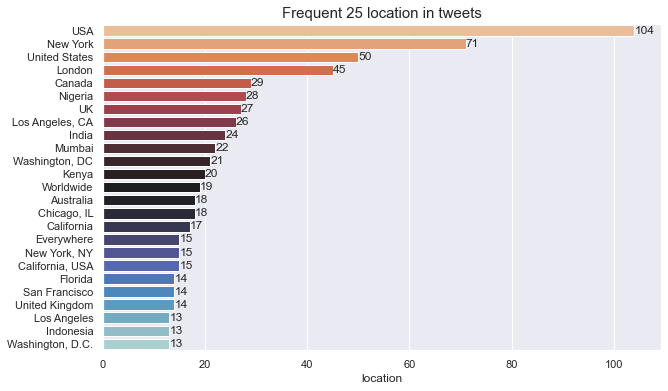

In [116]:
freq_no=25
freq_keywords=df_train["location"].value_counts()[:freq_no]
fig,ax = plt.subplots(figsize=(10,6))
ax=sns.barplot(y=freq_keywords.index,x=freq_keywords,data=df_train,palette="icefire_r")

for container in ax.containers:
    ax.bar_label(container)
plt.title(f"Frequent {freq_no} location in tweets",fontsize=15)
plt.show()

#### It's seems that most of the tweet's locations come from USA, New York, United states and London.

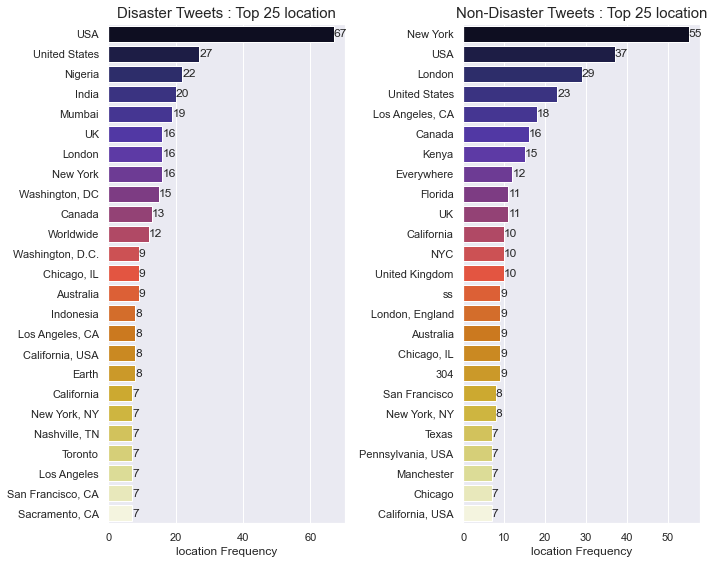

In [117]:
freq_disaster_keywords = df_train.loc[df_train["target"] == 1]["location"].value_counts()[:freq_no]
freq_nondisaster_keywords = df_train.loc[df_train["target"] == 0]["location"].value_counts()[:freq_no]

fig, ax = plt.subplots(1,2, figsize=(10,8))
ax1 = sns.barplot(y=freq_disaster_keywords.index, x=freq_disaster_keywords, orient='h', ax=ax[0], palette="CMRmap")
for container in ax1.containers:
    ax1.bar_label(container)
ax[0].set_title(f"Disaster Tweets : Top {freq_no} location",fontsize=15)
ax[0].set_xlabel("location Frequency")

ax2 = sns.barplot(y=freq_nondisaster_keywords.index, x= freq_nondisaster_keywords, orient='h', ax=ax[1], palette="CMRmap")
for container in ax2.containers:
    ax2.bar_label(container)
ax[1].set_title(f"Non-Disaster Tweets : Top {freq_no} location",fontsize=15)
ax[1].set_xlabel("location Frequency")

plt.tight_layout()
plt.show()

#### From above, Even though most of the tweet's locations come from USA, New York, United states and London, Disaster tweets are mostly from USA and the United states.

<button type="button" class="btn btn-primary btn-lg btn-block"> Feature Engineering</button></button>
- First, Let us extract new features from data set and find out how they affect the disaster tweets

In [118]:
def word_count(x):
    length=len(str(x).split())
    return length

def char_count(x):
    s=x.split()
    x="".join(s)
    return len(x)

def average_word_count(x):
    return round(char_count(x)/word_count(x),2)

def stopword_count(x):
    length= len([t for t in x.split() if t in stopwords_spacy])
    return length

def lower_sentence(x):
    return x.lower()

In [119]:
df_train["word_count"]=df_train["text"].apply(lambda x: word_count(x))
df_train["char_count"]=df_train["text"].apply(lambda x: char_count(x))
df_train["average_word_count"]=df_train["text"].apply(lambda x: average_word_count(x))
df_train["text"]=df_train["text"].apply(lambda x: lower_sentence(x))
print("shape of train dataset:",df_train.shape)
df_train.head()

shape of train dataset: (7613, 8)


,id,keyword,location,text,target,word_count,char_count,average_word_count
0,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1,13,57,4.38
1,4,NaN,NaN,forest fire near la ronge sask. canada,1,7,32,4.57
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1,22,112,5.09
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,57,7.12
4,7,NaN,NaN,just got sent this photo from ruby #alaska as ...,1,16,72,4.50


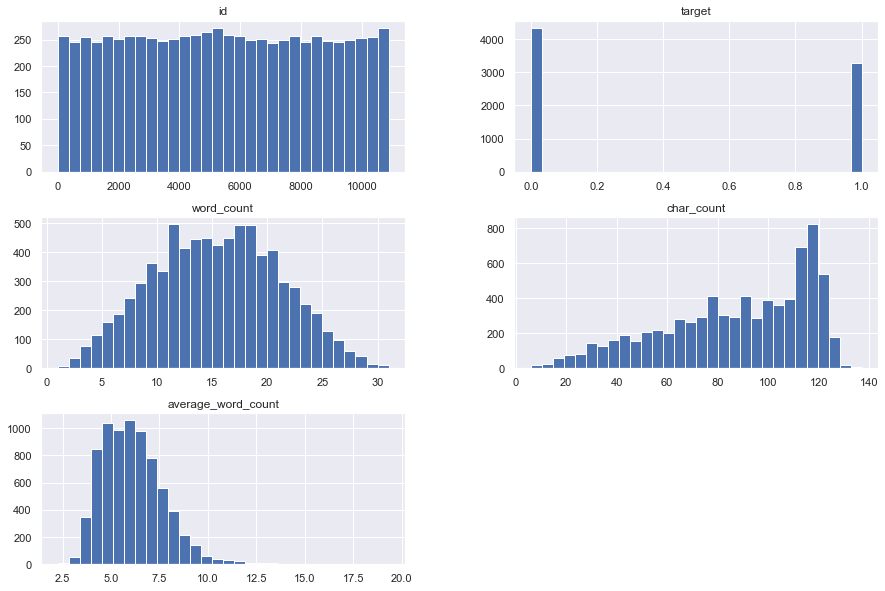

In [120]:
df_train.hist(bins=30,figsize=(15,10))
plt.show()

In [121]:
df_train[["word_count","char_count","average_word_count"]].agg(["skew","kurtosis"]).transpose()

,skew,kurtosis
word_count,0.022428,-0.614252
char_count,-0.613045,-0.637370
average_word_count,1.170586,3.387760


#### char_count is a left skew thus we need to convert the data distribution to positive in order to apply log or sqrt transformation.

In [122]:
df_train["char_count_positive"] = max(df_train["char_count"]) + 1 - df_train["char_count"]
df_train[["char_count_positive", "char_count"]].agg('skew')

char_count_positive    0.613045
char_count            -0.613045
dtype: float64

In [123]:
df_train["word_count_log"]=np.log(df_train["word_count"])
df_train["char_count_log"]=np.log(df_train["char_count_positive"])
df_train["average_word_count_log"]=np.log(df_train["average_word_count"])

# Log transform does not apply when zero or negative values exist in data,
# therefore it can demonstrate NaN values for skew or kurtosis
# we dont transform stopwords_count as it's moderately skew

df_train["word_count_sqrt"]=np.sqrt(df_train["word_count"])
df_train["char_count_sqrt"]=np.sqrt(df_train["char_count_positive"])
df_train["average_word_count_sqrt"]=np.sqrt(df_train["average_word_count"])

df_train[["word_count","word_count_log","word_count_sqrt","char_count_positive","char_count_log","char_count_sqrt",\
          "average_word_count","average_word_count_log","average_word_count_sqrt"]].agg(["skew","kurtosis"]).transpose()

,skew,kurtosis
word_count,0.022428,-0.614252
word_count_log,-1.219533,2.145754
word_count_sqrt,-0.483853,-0.128699
char_count_positive,0.613045,-0.637370
char_count_log,-0.213370,-0.863264
char_count_sqrt,0.221778,-1.047974
average_word_count,1.170586,3.387760
average_word_count_log,0.165882,0.107754
average_word_count_sqrt,0.611002,1.048169


#### Above table;
- We don't need to change word_count distribution as it's close to normal distribution.
-  We can use char_count_sqrt transformed from char_count.
-  average_word_count_log shows ideal skew value.

Text(0.5, 1.0, 'char_count_sqrt')

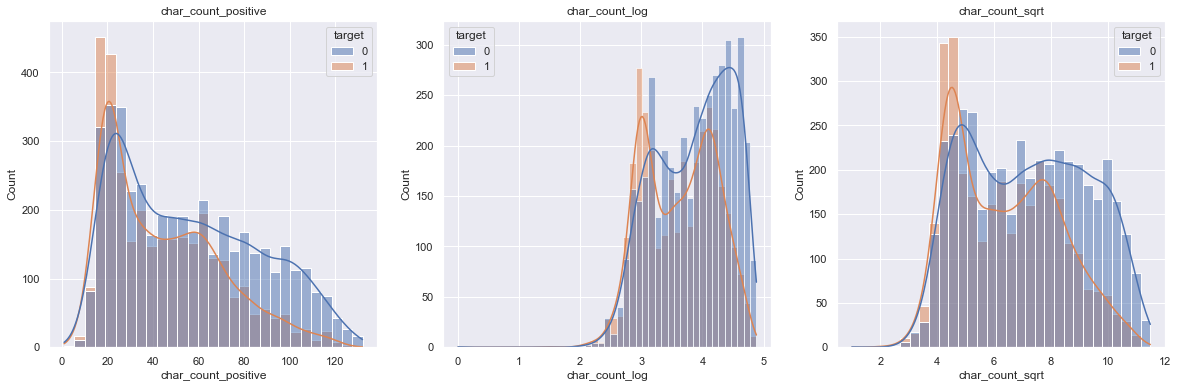

In [124]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,6))
sns.histplot(data=df_train,x="char_count_positive",hue="target",ax=ax1,kde=True)
ax1.set_title("char_count_positive")
sns.histplot(data=df_train,x="char_count_log",hue="target",ax=ax2,kde=True)
ax2.set_title("char_count_log")
sns.histplot(data=df_train,x="char_count_sqrt",hue="target",ax=ax3,kde=True)
ax3.set_title("char_count_sqrt")

Text(0.5, 1.0, 'word_count_sqrt')

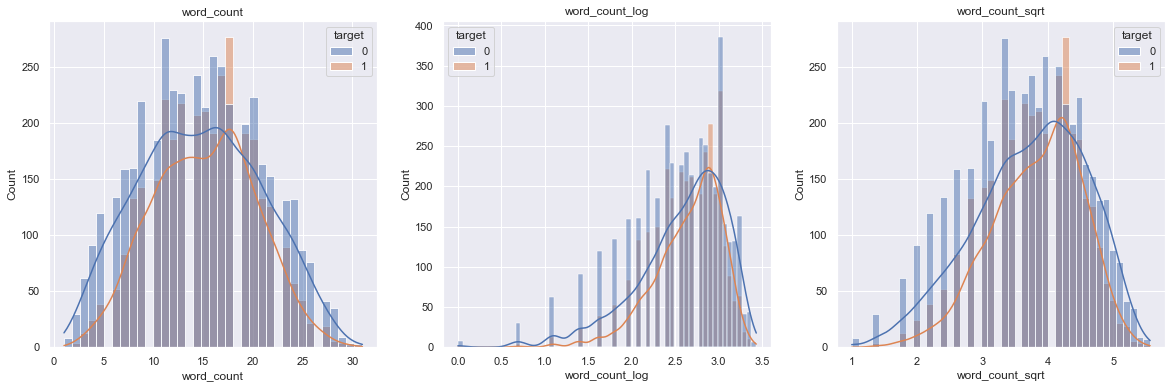

In [125]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,6))
sns.histplot(data=df_train,x="word_count",hue="target",ax=ax1,kde=True)
ax1.set_title("word_count")
sns.histplot(data=df_train,x="word_count_log",hue="target",ax=ax2,kde=True)
ax2.set_title("word_count_log")
sns.histplot(data=df_train,x="word_count_sqrt",hue="target",ax=ax3,kde=True)
ax3.set_title("word_count_sqrt")

Text(0.5, 1.0, 'average_word_count_sqrt')

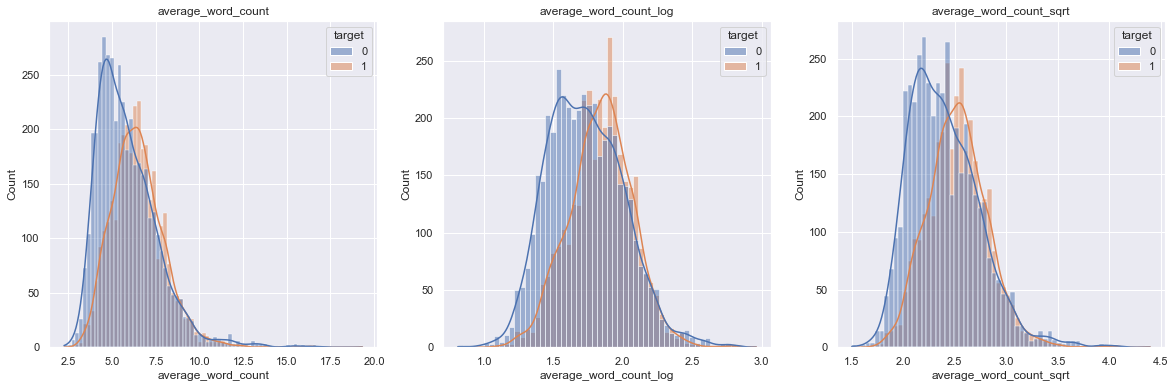

In [126]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,6))
sns.histplot(data=df_train,x="average_word_count",hue="target",ax=ax1,kde=True)
ax1.set_title("average_word_count")
sns.histplot(data=df_train,x="average_word_count_log",hue="target",ax=ax2,kde=True)
ax2.set_title("average_word_count_log")
sns.histplot(data=df_train,x="average_word_count_sqrt",hue="target",ax=ax3,kde=True)
ax3.set_title("average_word_count_sqrt")

<button type="button" class="btn btn-primary btn-lg btn-block">Data Preprocessing</button></button>

In [127]:
# This function is taken from link and modified for this project.
# Link:https://www.geeksforgeeks.org/python-lemmatization-approaches-with-examples/ 
# WORDNET LEMMATIZER (with appropriate pos tags)

# POS_TAGGER_FUNCTION : TYPE 1
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None

def lemmatize_func(sentence):
    # Define function to lemmatize each word with its POS tag
    lemmatizer = WordNetLemmatizer()
    # tokenize the sentence and find the POS tag for each token
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(sentence)) 
    # we use our own pos_tagger function to make things simpler to understand.
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            # if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:       
            # else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    lemmatized_sentence = " ".join(lemmatized_sentence)
    return lemmatized_sentence

# Example
# lemmatize_func("the cat is sitting with the bat on the striped mat under many flying goose")
#> the cat can be sit with the bat on the striped mat under many fly geese

def get_contraction(x):
    return contractions.fix(x)

def remove_emails(x):
    return re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+\b)',"",x)

def remove_urls(x):
    return re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?',"",x)

def remove_punctuation(x):
    return x.translate(str.maketrans('', '', string.punctuation))

def remove_rt(x):
    return re.sub(r"\brt\b","",x).strip()

def remove_html_tags(x):
    return BeautifulSoup(x,"lxml").get_text().strip()

def remove_accented_chars(x):
    x = unicodedata.normalize("NFKD",x).encode("ascii","ignore").decode("utf-8","ignore")
    return x

def remove_stopwords(x):
    return " ".join([ t for t in x.split() if t not in stopwords_spacy])

def clean_data(x):
    x=get_contraction(x)
    x=remove_emails(x)
    x=remove_urls(x)
    x=remove_html_tags(x)
    x=remove_rt(x)
    x=remove_accented_chars(x)
    x=remove_punctuation(x)
    x=re.sub("(.)\\1{2,}","\\1",x)
    x=remove_stopwords(x)
    x=lemmatize_func(x)
    
    return x

In [128]:
df_train=df_train[['id', 'keyword', 'location', 'text', 'target', 'word_count',
       'average_word_count_log','char_count_sqrt']]
df_train.head()

,id,keyword,location,text,target,word_count,average_word_count_log,char_count_sqrt
0,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1,13,1.477049,9.000000
1,4,NaN,NaN,forest fire near la ronge sask. canada,1,7,1.519513,10.295630
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1,22,1.627278,5.099020
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,1.962908,9.000000
4,7,NaN,NaN,just got sent this photo from ruby #alaska as ...,1,16,1.504077,8.124038


In [129]:
df_train_unclean=df_train.copy()

In [130]:
#clean data
df_train["text"]=df_train["text"].apply(lambda x: clean_data(x))

c:\users\developer\appdata\local\programs\python\python38\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [131]:
# Display original and clean text
import random
random_list= random.sample(range(len(df_train)), 5)
for i in random_list:
    print("original text: -->",df_train_unclean["text"][i])
    print("clean text: ----->",df_train["text"][i])
    print("-"*30)

original text: --> kids got disney version of the game operation only 2 aa batteries? i swear my old version had like 8 ds and would nearly electrocute you.
clean text: -----> kid get disney version game operation 2 aa battery swear old version like 8 d nearly electrocute
------------------------------
original text: --> fire hazard associated with installation of non-compliant external cladding on high-rise buildings - insurance - aust http://t.co/wfseaobato
clean text: -----> fire hazard associate installation noncompliant external cladding highrise building insurance aust
------------------------------
original text: --> #hot  c-130 specially modified to land in a stadium and rescue hostages in iran in 1980 http://t.co/zy3hpdjnwg #prebreak #best
clean text: -----> hot c130 specially modified land stadium rescue hostage iran 1980 prebreak best
------------------------------
original text: --> maryland mansion fire that killed 6 caused by damaged plug under christmas tree report says 

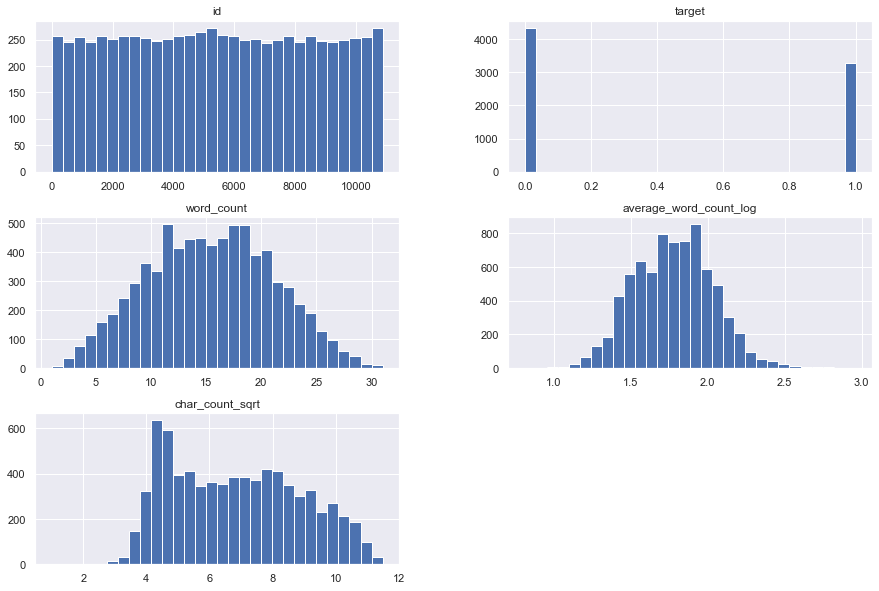

In [132]:
df_train.hist(bins=30,figsize=(15,10))
plt.show()

#### Find out Outliers for features : word_count	char_count	average_word_count	mention_count	hashtag_count

lower limit: -1.0 and upper limit: 31.0 for feature ------> word_count
lower limit: 1.0311954724049135 and upper limit: 2.508394798965293 for feature ------> average_word_count_log
lower limit: -0.13922465976453857 and upper limit: 13.565374432940898 for feature ------> char_count_sqrt


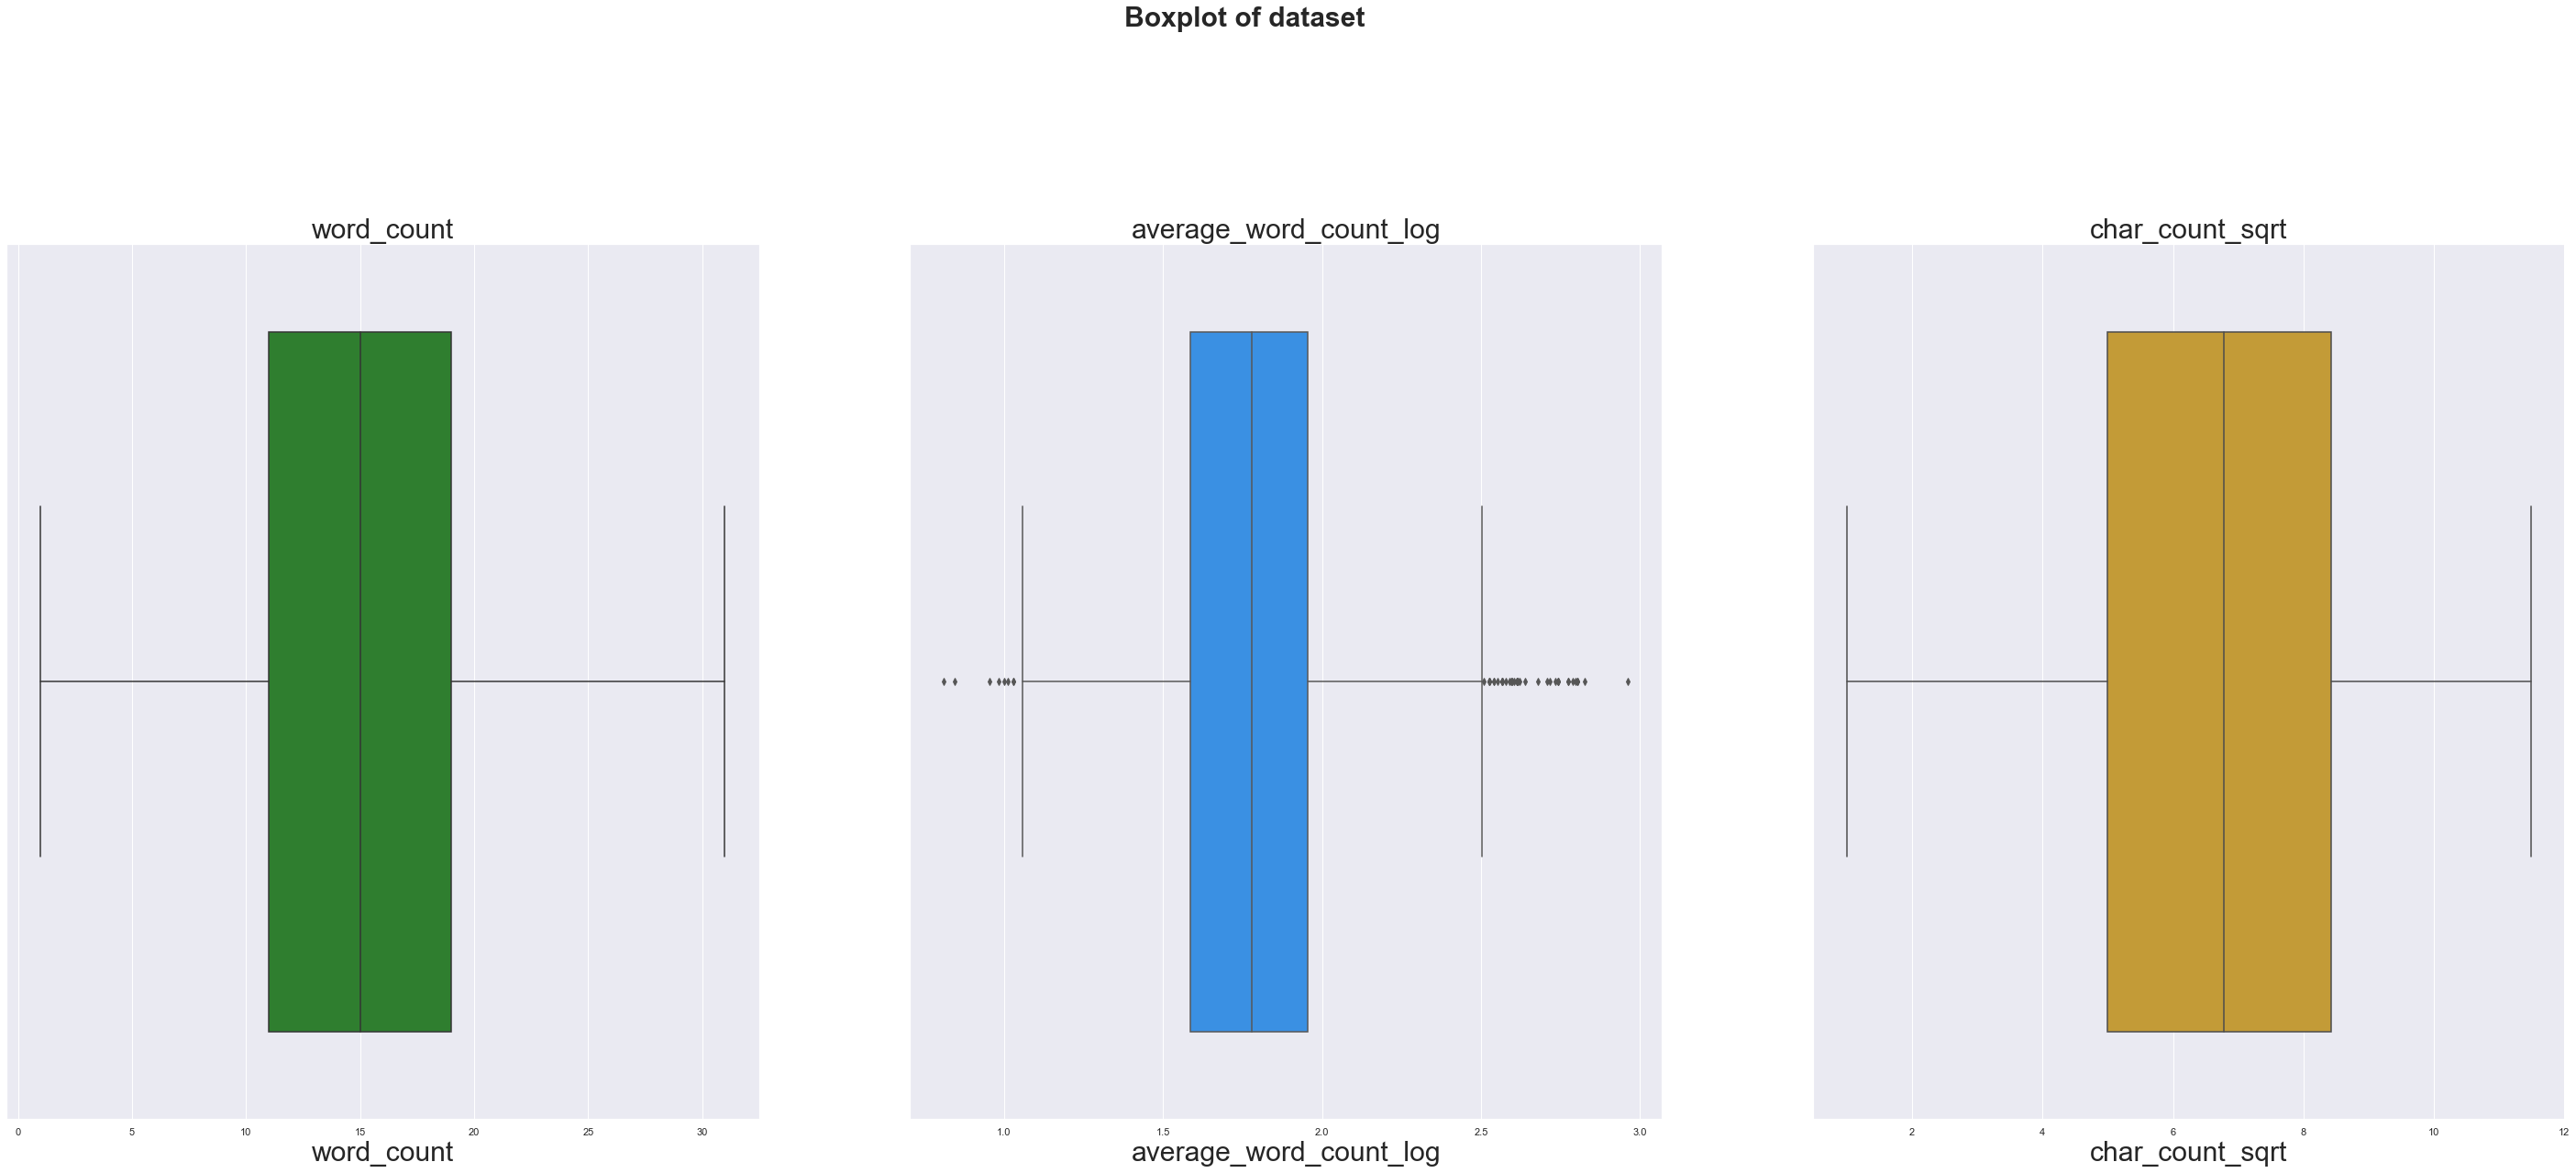

In [133]:
outlier_features_list=['word_count','average_word_count_log','char_count_sqrt']
outlier_dict={}
for i in outlier_features_list:
    q1=df_train[i].quantile(0.25)
    q3=df_train[i].quantile(0.75)
    IQR=q3-q1
    lower,upper=q1-1.5*IQR, q3+1.5*IQR
    outlier_dict[i+"_"+"lower and upper"]=round(lower,2),round(upper,2)
    print(f"lower limit: {lower} and upper limit: {upper} for feature ------> {i}")
    
# Also plot outliers using seaborn boxplot
fig = plt.figure(figsize=[50,60])
fig.suptitle('Boxplot of dataset', fontsize=30, fontweight='bold')
fig.subplots_adjust(top=0.92);
fig.subplots_adjust(hspace=0.3, wspace=0.2);
colours = ['forestgreen','dodgerblue','goldenrod', 'coral' ,'purple','indigo','red','palegreen','sienna','pink','violet','slateblue',
           'maroon','chocolate','teal','magenta','coral','peru','slategray','lawngreen'];
for i ,col in enumerate(outlier_features_list):
    ax1 = fig.add_subplot(3,3, i+1);
    ax1 = sns.boxplot(data = df_train, x=col,color=colours[i]);
    ax1.set_title(f'{col}',fontsize=30) 
    ax1.set_xlabel(f'{col}',fontsize=30)

In [134]:
outlier_dict

{'word_count_lower and upper': (-1.0, 31.0),
 'average_word_count_log_lower and upper': (1.03, 2.51),
 'char_count_sqrt_lower and upper': (-0.14, 13.57)}

In [135]:
low=outlier_dict['average_word_count_log_lower and upper'][0]
up=outlier_dict['average_word_count_log_lower and upper'][1]
temp=df_train[( (df_train["average_word_count_log"]<low) | (df_train["average_word_count_log"]>up) )]
print("Number of total outliers", len(temp))
temp
# compared to dataset lenght, we can leave the outliers of average_word_count as it is

Number of total outliers 48


,id,keyword,location,text,target,word_count,average_word_count_log,char_count_sqrt
18,26,NaN,NaN,car fast,0,5,0.955511,11.180340
40,59,ablaze,Live On Webcam,check nsfw,0,8,2.593761,5.567764
48,68,ablaze,Live On Webcam,check nsfw,0,8,2.593761,5.567764
113,163,aftershock,Belgium,aftershock,0,2,2.803360,10.246951
131,190,aftershock,NaN,aftershock,0,2,2.803360,10.246951
255,363,annihilation,United States,soul punish withaeannihilation,0,6,2.577942,7.681146
321,467,armageddon,Here And There,armageddon,1,2,2.803360,10.246951
323,469,armageddon,"Derry, 17",paddytomlinson1 armageddon,0,2,2.564949,10.583005
390,564,arson,Zero Branco,wait,0,4,2.621039,9.110434
675,976,blaze,Gotham City,yes 2 gun,0,9,0.845868,10.816654


In [136]:
total_words=[y.lower() for x in df_train["text"] for y in x.split() if isinstance(y,str)]
word_count_dict = dict(Counter(total_words))

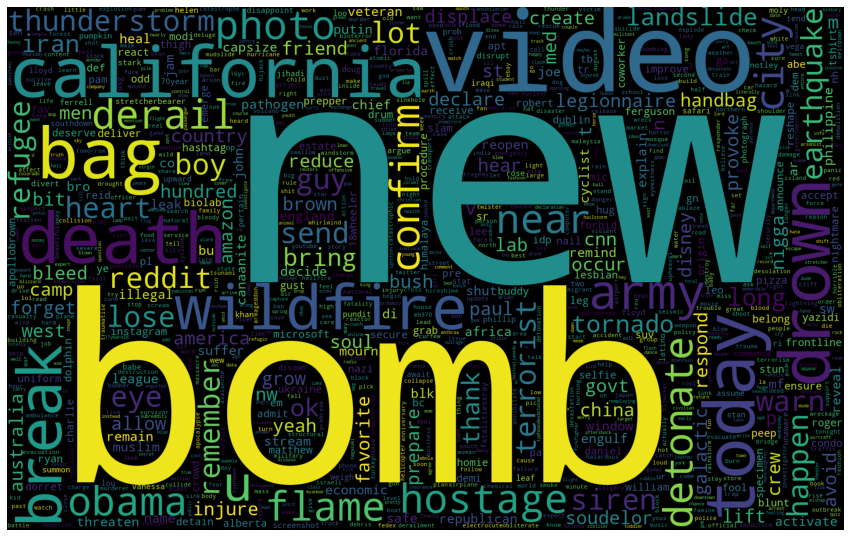

In [137]:
def wordCloudFunction(df,column,numWords):
    total_words=[y.lower() for x in df[column] for y in x.split() if isinstance(y,str)]
    word_count_dict = dict(Counter(total_words))
    common_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    wordcloud = WordCloud(background_color='black',
                          max_words=numWords,
                          width=1600,height=1000,
                         ).generate(" ".join(common_words))
    plt.imshow(wordcloud)
#     plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.show()
    return common_words,word_count_dict
    
plt.figure(figsize=(15,15))
cm,cm_dict=wordCloudFunction(df_train,'text',1000)

#### Most common words for Target 1

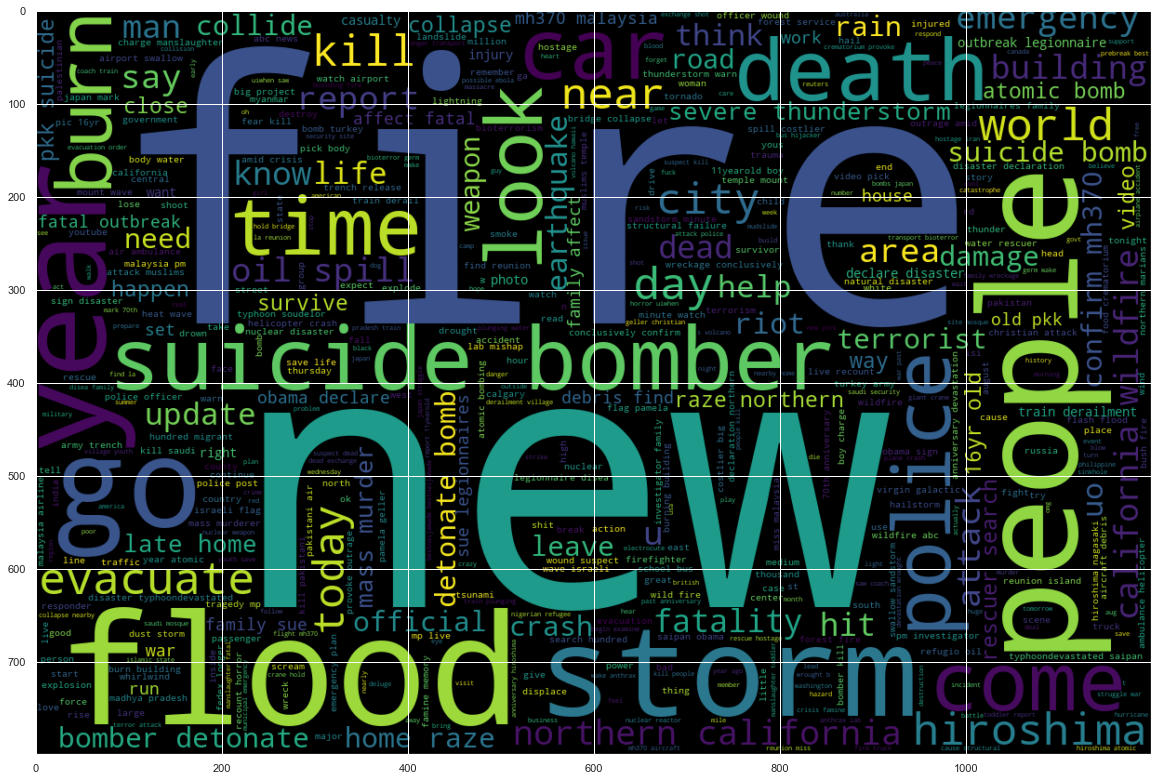

In [138]:
from wordcloud import WordCloud
plt.figure(figsize = (20,20)) # Text that is not fraudulent(0)
wc = WordCloud(width = 1200 , height = 800 , max_words = 500,background_color='black').generate(" ".join(df_train[df_train["target"]==1].text))
plt.imshow(wc , interpolation = 'bilinear')

#### Plot first 50 common words for Target 1

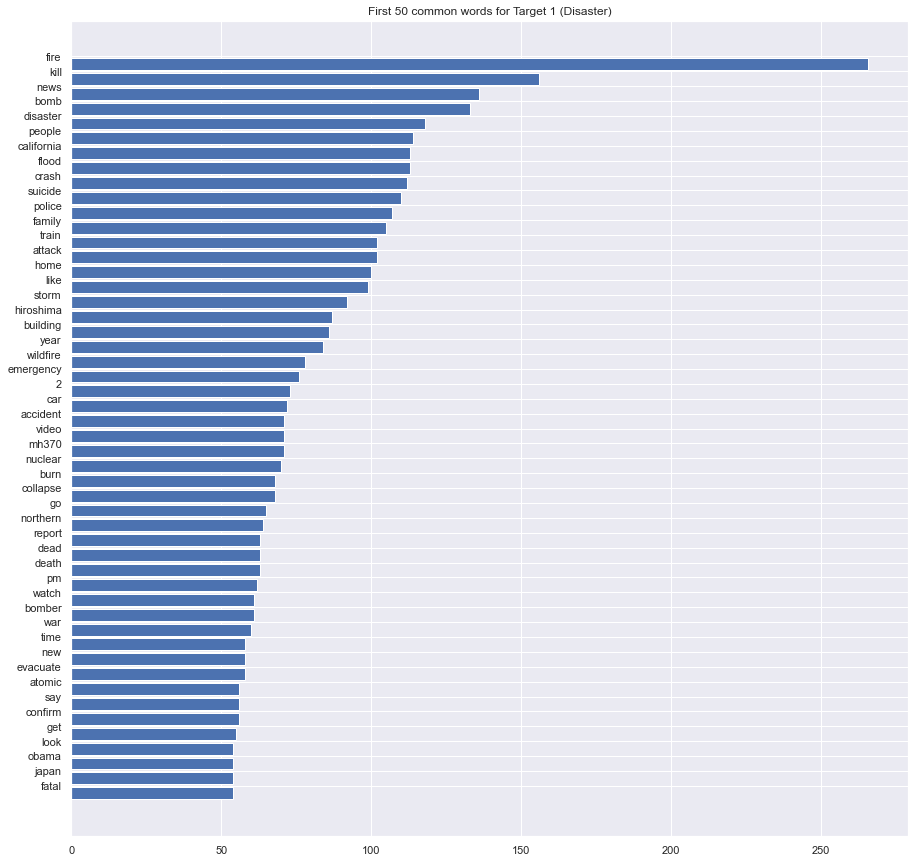

In [139]:
total_words=[y.lower() for x in df_train[df_train["target"]==1]["text"] for y in x.split() if isinstance(y,str)]
word_count_dict = dict(Counter(total_words))
common_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)

plt.figure(figsize=(15,15))
plt.barh(range(50), [word_count_dict[w] for w in reversed(common_words[0:50])])
plt.yticks([x + 0.5 for x in range(50)], reversed(common_words[0:50]))
plt.title("First 50 common words for Target 1 (Disaster)")
plt.show()

#### Most common words for Target 0

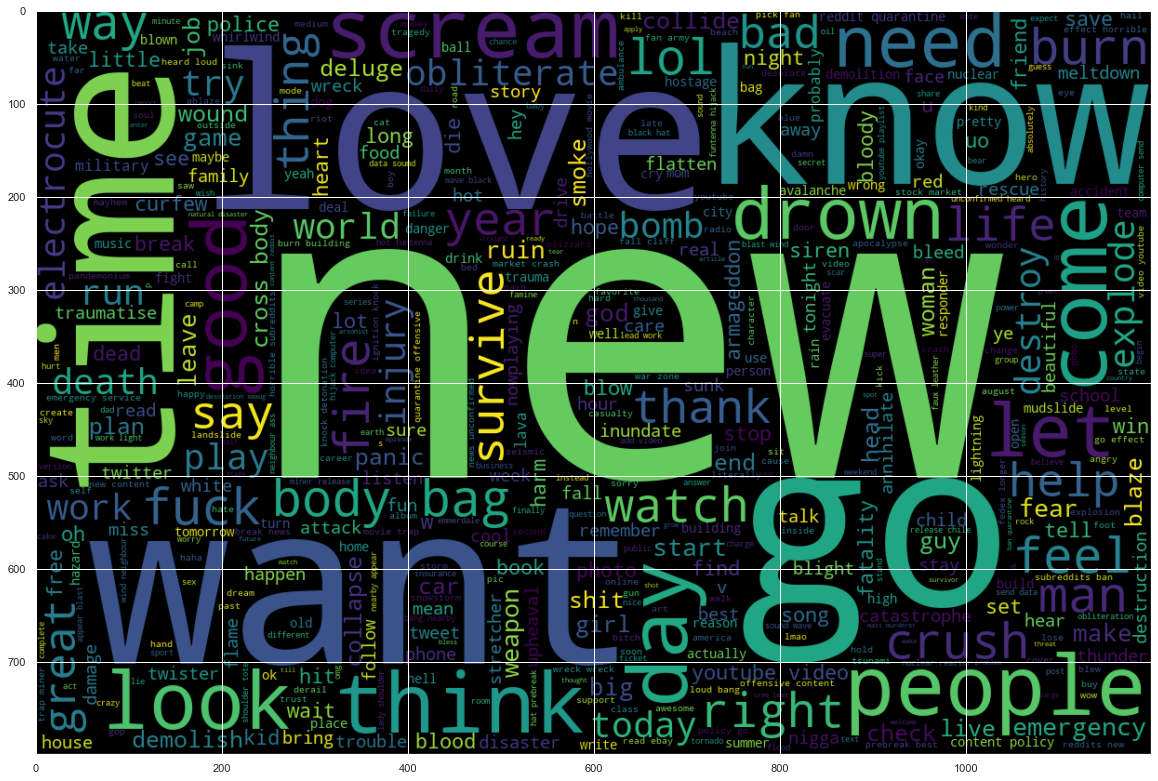

In [140]:
from wordcloud import WordCloud
plt.figure(figsize = (20,20)) # Text that is not fraudulent(0)
wc = WordCloud(width = 1200 , height = 800 , max_words = 500,background_color='black').generate(" ".join(df_train[df_train["target"]==0].text))
plt.imshow(wc , interpolation = 'bilinear')

#### Plot first 50 common words for Target 0

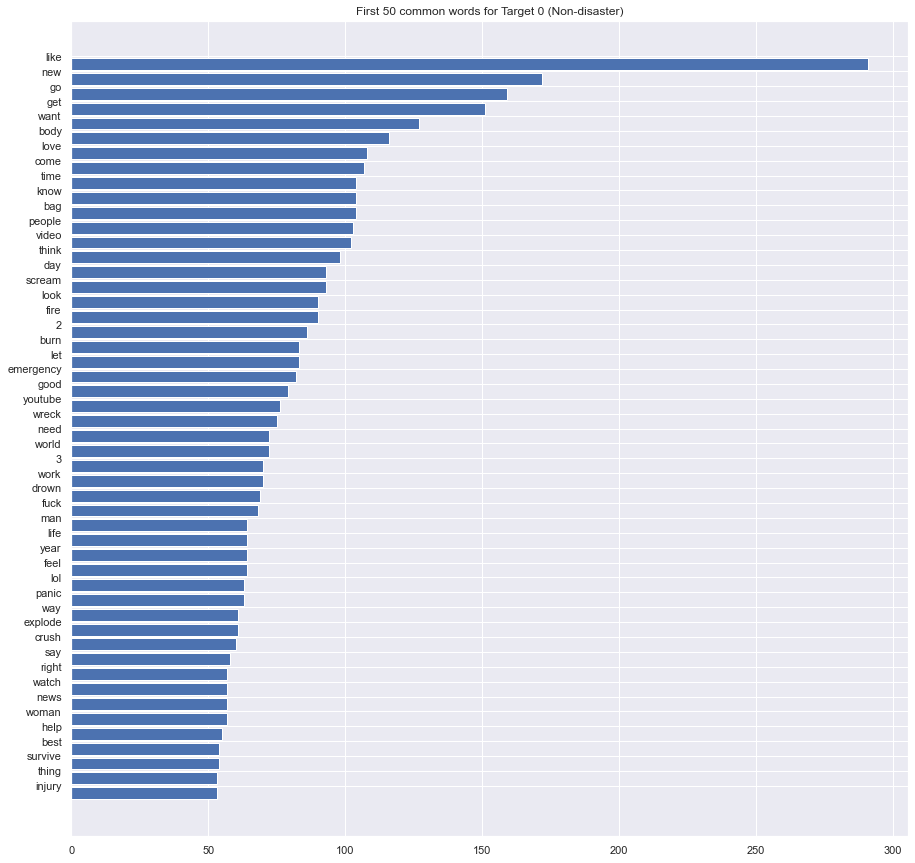

In [141]:
total_words=[y.lower() for x in df_train[df_train["target"]==0]["text"] for y in x.split() if isinstance(y,str)]
word_count_dict = dict(Counter(total_words))
common_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)

plt.figure(figsize=(15,15))
plt.barh(range(50), [word_count_dict[w] for w in reversed(common_words[0:50])])
plt.yticks([x + 0.5 for x in range(50)], reversed(common_words[0:50]))
plt.title("First 50 common words for Target 0 (Non-disaster)")
plt.show()

In [142]:
df_train.head()

,id,keyword,location,text,target,word_count,average_word_count_log,char_count_sqrt
0,1,NaN,NaN,deed reason earthquake allah forgive,1,13,1.477049,9.000000
1,4,NaN,NaN,forest fire near la ronge sask canada,1,7,1.519513,10.295630
2,5,NaN,NaN,resident ask shelter place notify officer evac...,1,22,1.627278,5.099020
3,6,NaN,NaN,130 people receive wildfire evacuation order c...,1,8,1.962908,9.000000
4,7,NaN,NaN,get sent photo ruby alaska smoke wildfires pou...,1,16,1.504077,8.124038


#### Check if there is duplicated text in preprocessed data

In [143]:
list(df_train[df_train["text"].duplicated()]["text"])

['check nsfw',
 '320 ir icemoon aftershock djicemoon dubstep trapmusic dnb edm dance icesu',
 '320 ir icemoon aftershock djicemoon dubstep trapmusic dnb edm dance icesu',
 '320 ir icemoon aftershock djicemoon dubstep trapmusic dnb edm dance icesu',
 '320 ir icemoon aftershock djicemoon dubstep trapmusic dnb edm dance icesu',
 '320 ir icemoon aftershock djicemoon dubstep trapmusic dnb edm dance icesu',
 '320 ir icemoon aftershock djicemoon dubstep trapmusic dnb edm dance icesu',
 'aftershock',
 'horrible accident man die wing airplane 29072015',
 'expert france begin examine airplane debris find reunion island french air accident expert wedn',
 'expert france begin examine airplane debris find reunion island french air accident expert wednesday begin examine t',
 'fear kill pakistani air ambulance helicopter crash',
 'fear kill pakistani air ambulance helicopter crash',
 'ambulance sprinter automatic frontline vehicle choice 14 lez compliant ebay',
 'fear kill pakistani air ambulance he

In [144]:
df_train["text"][4326]

'0day bug fully patch o x come active exploit bypass password ars technica'

In [145]:
df_train["text"][4339]

'0day bug fully patch o x come active exploit bypass password ars technica'

#### Remove duplicate tweets

In [146]:
print("Original shape of dataset with duplicate tweets")
df_train.drop_duplicates(subset="text", keep="first",inplace=True)
df_train.reset_index(inplace=True,drop=True)
print("New shape of dataset without duplicate tweets:",df_train.shape)

Original shape of dataset with duplicate tweets
New shape of dataset without duplicate tweets: (6886, 8)


<button type="button" class="btn btn-primary btn-lg btn-block">Disaster Analysis using Machine Learning</button></button>

In [147]:
text=df_train["text"]
y=df_train["target"]

In [148]:
# tfidf=TfidfVectorizer()
# X=tfidf.fit_transform(text)
from sklearn_deltatfidf import DeltaTfidfVectorizer
tfidf = DeltaTfidfVectorizer()
X=tfidf.fit_transform(list(text),list(y))
X.shape

(6886, 15637)

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [150]:
X_train.shape

(5508, 15637)

In [151]:
X_test.shape

(1378, 15637)

### LGBMClassifier

Accuracy on Validation set : 0.7634252539912917


              precision    recall  f1-score   support

           0       0.77      0.86      0.81       815
           1       0.75      0.63      0.68       563

    accuracy                           0.76      1378
   macro avg       0.76      0.74      0.75      1378
weighted avg       0.76      0.76      0.76      1378

Confusion Matrix : 


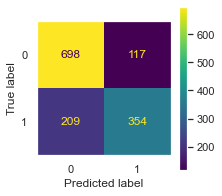

In [152]:
from sklearn.metrics import classification_report,accuracy_score
from sklearn import metrics
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(objective="binary",random_state=42)
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)
print('Accuracy on Validation set :',accuracy_score(y_test, y_pred_lgbm))
print("\n")
print(classification_report(y_test, y_pred_lgbm))
print('Confusion Matrix : \n',metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lgbm))
plt.grid(False)

### CatBoostClassifier

Accuracy on Validation set : 0.7692307692307693


              precision    recall  f1-score   support

           0       0.78      0.86      0.81       815
           1       0.75      0.64      0.70       563

    accuracy                           0.77      1378
   macro avg       0.77      0.75      0.75      1378
weighted avg       0.77      0.77      0.77      1378

Confusion Matrix : 


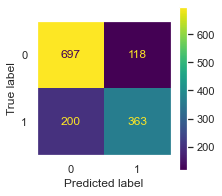

In [153]:
from catboost import CatBoostClassifier
cbc = CatBoostClassifier(learning_rate=0.4,random_seed=42,verbose=False)
cbc.fit(X_train, y_train)
y_pred_cbc = cbc.predict(X_test)
print('Accuracy on Validation set :',accuracy_score(y_test, y_pred_cbc))
print("\n")
print(classification_report(y_test, y_pred_cbc))
print('Confusion Matrix : \n',metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred_cbc))
plt.grid(False)

#### GridSearchCV as additional approach

In [58]:
# from sklearn.model_selection import GridSearchCV
# parameters = {'depth'         : [4,5,6,7,8,9, 10],
#              'learning_rate' : [0.01,0.1,0.4,0.6],
#               'iterations'    : [10, 20,30,40,50,60,70,80,90, 100]
#              }
# Grid_CBC = GridSearchCV(estimator=cbc, param_grid = parameters, cv = 4, n_jobs=-1)
# Grid_CBC.fit(X_train, y_train)

In [59]:
import catboost as cb
import optuna
def objective(trial):
    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = cb.CatBoostClassifier(**param)

    gbm.fit(X_train, y_train, verbose=0, early_stopping_rounds=100)

    preds = gbm.predict(X_test)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_test, pred_labels)
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10, timeout=600)

[I 2022-10-03 10:42:15,018] A new study created in memory with name: no-name-1f97a6c4-ab44-4476-9eca-91ae4b0534c6
[I 2022-10-03 10:42:39,012] Trial 0 finished with value: 0.7264150943396226 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.05933954585175665, 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.321302702693071}. Best is trial 0 with value: 0.7264150943396226.
[I 2022-10-03 10:49:49,901] Trial 1 finished with value: 0.7786647314949202 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.010305897582213874, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.07228338255742872}. Best is trial 1 with value: 0.7786647314949202.
[I 2022-10-03 10:51:01,812] Trial 2 finished with value: 0.7743105950653121 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.027180741733655887, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is 

In [60]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 4
Best trial:
  Value: 0.7786647314949202
  Params: 
    objective: CrossEntropy
    colsample_bylevel: 0.010305897582213874
    depth: 9
    boosting_type: Plain
    bootstrap_type: Bayesian
    bagging_temperature: 0.07228338255742872


In [64]:
study.best_trial.params

{'objective': 'CrossEntropy',
 'colsample_bylevel': 0.010305897582213874,
 'depth': 9,
 'boosting_type': 'Plain',
 'bootstrap_type': 'Bayesian',
 'bagging_temperature': 0.07228338255742872}

Accuracy on Validation set : 0.7706821480406386


              precision    recall  f1-score   support

           0       0.77      0.88      0.82       815
           1       0.78      0.61      0.68       563

    accuracy                           0.77      1378
   macro avg       0.77      0.75      0.75      1378
weighted avg       0.77      0.77      0.76      1378

Confusion Matrix : 


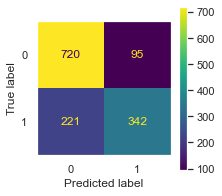

In [154]:
from catboost import CatBoostClassifier
cbc = CatBoostClassifier(objective="CrossEntropy",colsample_bylevel=0.010305897582213874,boosting_type='Plain',\
                         bootstrap_type="Bayesian", bagging_temperature=0.07228338255742872,learning_rate=0.1,\
                         random_seed=42,depth=9,verbose=False)
cbc.fit(X_train, y_train)
y_pred_cbc = cbc.predict(X_test)
print('Accuracy on Validation set :',accuracy_score(y_test, y_pred_cbc))
print("\n")
print(classification_report(y_test, y_pred_cbc))
print('Confusion Matrix : \n',metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred_cbc))
plt.grid(False)

### RandomForestClassifier

Accuracy on Validation set : 0.7706821480406386


              precision    recall  f1-score   support

           0       0.76      0.89      0.82       815
           1       0.79      0.60      0.68       563

    accuracy                           0.77      1378
   macro avg       0.78      0.74      0.75      1378
weighted avg       0.77      0.77      0.76      1378

Confusion Matrix : 


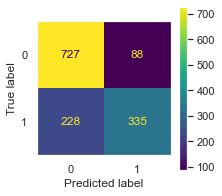

In [155]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print('Accuracy on Validation set :',accuracy_score(y_test, y_pred_rf))
print("\n")
print(classification_report(y_test, y_pred_rf))
print('Confusion Matrix : \n',metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf))
plt.grid(False)

In [73]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 100)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state=42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 4, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 4 folds for each of 100 candidates, totalling 400 fits


{'n_estimators': 981,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': True}

In [74]:
rf_random.best_params_

{'n_estimators': 981,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': True}

Accuracy on Validation set : 0.7873730043541364


              precision    recall  f1-score   support

           0       0.79      0.87      0.83       815
           1       0.78      0.66      0.72       563

    accuracy                           0.79      1378
   macro avg       0.79      0.77      0.77      1378
weighted avg       0.79      0.79      0.78      1378

Confusion Matrix : 


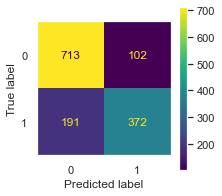

In [156]:
rf = RandomForestClassifier(random_state=42,n_estimators=981,min_samples_split=10,min_samples_leaf=2,max_features="sqrt",\
                        max_depth=None,bootstrap=True)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print('Accuracy on Validation set :',accuracy_score(y_test, y_pred_rf))
print("\n")
print(classification_report(y_test, y_pred_rf))
print('Confusion Matrix : \n',metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf))
plt.grid(False)

### XGBClassifier

Accuracy on Validation set : 0.7677793904208998


              precision    recall  f1-score   support

           0       0.76      0.89      0.82       815
           1       0.79      0.59      0.68       563

    accuracy                           0.77      1378
   macro avg       0.77      0.74      0.75      1378
weighted avg       0.77      0.77      0.76      1378

Confusion Matrix : 


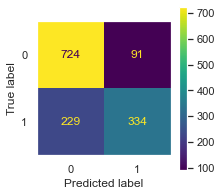

In [157]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print('Accuracy on Validation set :',accuracy_score(y_test, y_pred_xgb))
print("\n")
print(classification_report(y_test, y_pred_xgb))
print('Confusion Matrix : \n',metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb))
plt.grid(False)

In [107]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 50)]
max_depth = [int(x) for x in np.linspace(1, 110, num = 15)]
max_depth.append(None)
min_child_weight=[int(x) for x in np.linspace(start = 0, stop = 120, num = 30)]
params={
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'learning_rate': [0.05, 0.01, 0.1, 0.2],
    'min_child_weight': min_child_weight,
    'gamma': [0, 0.5, 1, 2, 3, 4, 5],
    'reg_alpha': [0, 0.1, 0.5, 0.7, 1],
    'reg_lambda': [0, 0.1, 0.5, 1, 5],
}
xgb = XGBClassifier(random_state=42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = params, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
xgb_random.fit(X_train, y_train)
xgb_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'reg_lambda': 0.1,
 'reg_alpha': 1,
 'n_estimators': 914,
 'min_child_weight': 0,
 'max_depth': 55,
 'learning_rate': 0.05,
 'gamma': 0.5}

Accuracy on Validation set : 0.7648766328011611


              precision    recall  f1-score   support

           0       0.79      0.82      0.81       815
           1       0.73      0.68      0.70       563

    accuracy                           0.76      1378
   macro avg       0.76      0.75      0.75      1378
weighted avg       0.76      0.76      0.76      1378

Confusion Matrix : 


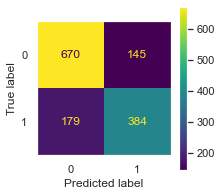

In [158]:
from xgboost import XGBClassifier
xgb = XGBClassifier(reg_lambda=0.1, reg_alpha=1, n_estimators=914, min_child_weight=0, max_depth=55,\
                    learning_rate=0.05,gamma=0.5)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print('Accuracy on Validation set :',accuracy_score(y_test, y_pred_xgb))
print("\n")
print(classification_report(y_test, y_pred_xgb))
print('Confusion Matrix : \n',metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb))
plt.grid(False)

#### Comparison of models with respect to Accuracy

In [159]:
print("Test accuracy of LightGBM model    :",accuracy_score(y_test, y_pred_lgbm))
print("Test accuracy on CatBoost model    :",accuracy_score(y_test, y_pred_cbc))
print("Test accuracy on RandomForest model:",accuracy_score(y_test, y_pred_rf))
print("Test accuracy on XGBoost model     :",accuracy_score(y_test, y_pred_xgb))

Test accuracy of LightGBM model    : 0.7634252539912917
Test accuracy on CatBoost model    : 0.7706821480406386
Test accuracy on RandomForest model: 0.7873730043541364
Test accuracy on XGBoost model     : 0.7648766328011611


#### Additional unused code to combine another features with tfidf matrix, you can use hstack just in case for information

In [160]:
# from scipy.sparse import hstack
# text=df_train["text"]
# yy=df_train["target"]
# tfidf=TfidfVectorizer(norm="l1")
# XX=tfidf.fit_transform(text)

# # XX=hstack([XX, df_train[["word_count"]]])
# XX=hstack([XX, df_train[["word_count","average_word_count","char_count"]]])
# X_train2, X_test2, y_train2, y_test2 = train_test_split(XX, yy, test_size=0.2, random_state=42,stratify=yy)


# rf2 = RandomForestClassifier(random_state=42,n_estimators=981,min_samples_split=10,min_samples_leaf=2,max_features="sqrt",\
#                         max_depth=None,bootstrap=True)
# rf2.fit(X_train2, y_train2)
# y_pred_rf2 = rf2.predict(X_test2)
# print('Accuracy on Validation set :',accuracy_score(y_test2, y_pred_rf2))
# print("\n")
# print(classification_report(y_test2, y_pred_rf2))
# print('Confusion Matrix : \n',metrics.ConfusionMatrixDisplay.from_predictions(y_test2, y_pred_rf2))
# plt.grid(False)

#### We will use RandomForest to predict disaster tweets, since it has demonstrated higher accuracy than the rest of models.

In [161]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


#### We need to clean test data

In [162]:
df_test["text"]=df_test["text"].apply(lambda x: clean_data(x))
df_test.head()

c:\users\developer\appdata\local\programs\python\python38\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


,id,keyword,location,text
0,0,NaN,NaN,Just happen terrible car crash
1,2,NaN,NaN,Heard earthquake different city stay safe
2,3,NaN,NaN,forest fire spot pond geese flee street I save
3,9,NaN,NaN,Apocalypse light Spokane wildfire
4,11,NaN,NaN,Typhoon Soudelor kill 28 China Taiwan


In [163]:
result=rf.predict(tfidf.transform(df_test["text"]))

In [164]:
disaster_tweet_prediction=pd.DataFrame()
disaster_tweet_prediction["id"]=df_test["id"]
disaster_tweet_prediction["target"]=result
disaster_tweet_prediction.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [171]:
disaster_tweet_prediction

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


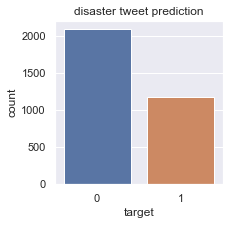

In [166]:
ax=sns.countplot(data=disaster_tweet_prediction,x="target")
plt.title("disaster tweet prediction")
sns.set(rc={'figure.figsize':(5,5)})

In [167]:
disaster_tweet_prediction.target.value_counts()

0    2091
1    1172
Name: target, dtype: int64

<AxesSubplot:ylabel='target'>

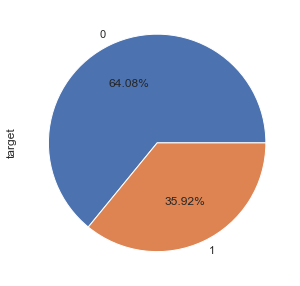

In [168]:
disaster_tweet_prediction["target"].value_counts().plot.pie(autopct="%1.2f%%")

In [169]:
disaster_tweet_prediction.to_csv("submission.csv",index=False)